# Variational Autoencoder

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mnist = input_data.read_data_sets('data-mnist/', one_hot=True)
n_samples = mnist.train.num_examples

Extracting data-mnist/train-images-idx3-ubyte.gz
Extracting data-mnist/train-labels-idx1-ubyte.gz
Extracting data-mnist/t10k-images-idx3-ubyte.gz
Extracting data-mnist/t10k-labels-idx1-ubyte.gz


## Task: fill the gaps in VAE 

In [5]:
class VAE:
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        self._create_network()
        self._create_loss_optimizer()

        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)
        config = tf.ConfigProto(gpu_options=gpu_options)
        
        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession(config=config)
        self.sess.run(init)

    def _create_network(self):
        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = self._recognition_network()

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        # tip: use tf.random_normal
        eps = tf.random_normal(shape=[n_z])
        
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = self._generator_network()

    def _recognition_network(self):
        layer_1 = slim.fully_connected(self.x, self.network_architecture['n_hidden_recog_1'])
        layer_2 = slim.fully_connected(layer_1, self.network_architecture['n_hidden_recog_2'])

        z_mean = slim.fully_connected(layer_2, self.network_architecture['n_z'], 
                                      activation_fn=None)
        z_log_sigma_sq = slim.fully_connected(layer_2, self.network_architecture['n_z'], 
                                              activation_fn=None)

        return z_mean, z_log_sigma_sq

    def _generator_network(self):
        layer_1 = slim.fully_connected(self.z, self.network_architecture['n_hidden_recog_1'])
        layer_2 = slim.fully_connected(layer_1, self.network_architecture['n_hidden_recog_2'])
        x_reconstr_mean = slim.fully_connected(layer_2, self.network_architecture['n_input'], 
                                               activation_fn=tf.nn.tanh)

        return x_reconstr_mean

    def _create_loss_optimizer(self):
        reconstr_loss = tf.reduce_sum(tf.square(tf.subtract(self.x, self.x_reconstr_mean)))

        net_normal_dist = tf.distributions.Normal(loc=self.z_mean,
                                                  scale=tf.sqrt(tf.exp(self.z_log_sigma_sq)))
        
        std_normal_dist = tf.distributions.Normal(loc=0.0, scale=1.0)
        
        latent_loss = tf.reduce_mean(tf.contrib.distributions.kl_divergence(net_normal_dist, 
                                                                            std_normal_dist))

        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})

In [6]:
def train(network_architecture, learning_rate=0.001,
          batch_size=1000, training_epochs=10, display_step=5):
    vae = VAE(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

## Visualize reconstruction quality

In [7]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

('Epoch:', '0001', 'cost=', '60200.504616477')
('Epoch:', '0006', 'cost=', '15477.581977983')
('Epoch:', '0011', 'cost=', '12302.605983665')
('Epoch:', '0016', 'cost=', '10939.487322443')
('Epoch:', '0021', 'cost=', '10130.697674006')
('Epoch:', '0026', 'cost=', '9602.458433949')
('Epoch:', '0031', 'cost=', '9273.027024148')
('Epoch:', '0036', 'cost=', '8956.318838778')
('Epoch:', '0041', 'cost=', '8731.365003551')
('Epoch:', '0046', 'cost=', '8507.129137074')
('Epoch:', '0051', 'cost=', '8362.189550781')
('Epoch:', '0056', 'cost=', '8201.846404474')
('Epoch:', '0061', 'cost=', '8085.445268111')
('Epoch:', '0066', 'cost=', '7989.832705966')
('Epoch:', '0071', 'cost=', '7875.835351563')


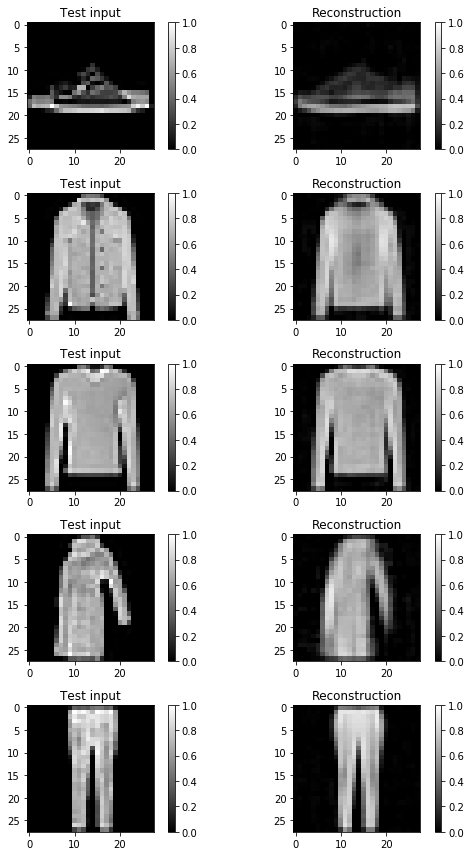

In [8]:
x_sample = mnist.test.next_batch(1000)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2 * i + 1)
    
    plt.imshow(x_sample[i].reshape(28, 28), 
               vmin=0, vmax=1, cmap="gray")
    
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2 * i + 2)
    
    plt.imshow(x_reconstruct[i].reshape(28, 28), 
               vmin=0, vmax=1, cmap="gray")
    
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [9]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

('Epoch:', '0001', 'cost=', '50491.999715909')
('Epoch:', '0006', 'cost=', '23881.911754261')
('Epoch:', '0011', 'cost=', '22053.123579545')
('Epoch:', '0016', 'cost=', '21258.063955966')
('Epoch:', '0021', 'cost=', '20772.772443182')
('Epoch:', '0026', 'cost=', '20378.238849432')
('Epoch:', '0031', 'cost=', '20085.739808239')
('Epoch:', '0036', 'cost=', '20009.025639205')
('Epoch:', '0041', 'cost=', '19712.487464489')
('Epoch:', '0046', 'cost=', '19449.062784091')
('Epoch:', '0051', 'cost=', '19333.974573864')
('Epoch:', '0056', 'cost=', '19120.491761364')
('Epoch:', '0061', 'cost=', '18948.323757102')
('Epoch:', '0066', 'cost=', '18947.017009943')
('Epoch:', '0071', 'cost=', '18828.455362216')


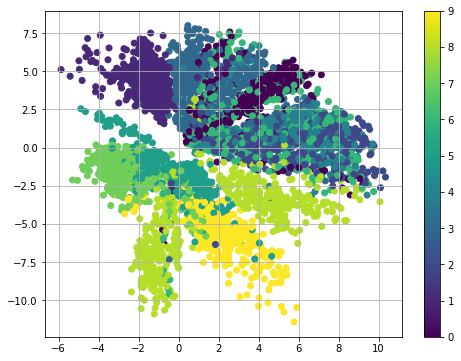

In [10]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

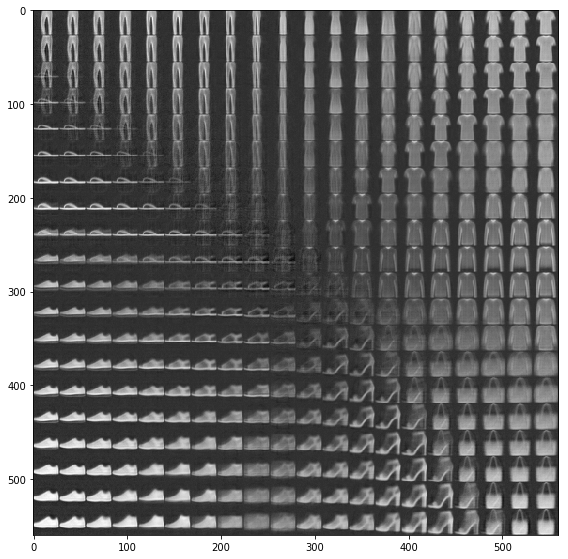

In [11]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()